In [3]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/4DCT/lib/pkgconfig'

In [4]:
import numpy as np
import fenics as fe
from fenics import grad, dot, dx, ds
import matplotlib.pyplot as plt

0.025

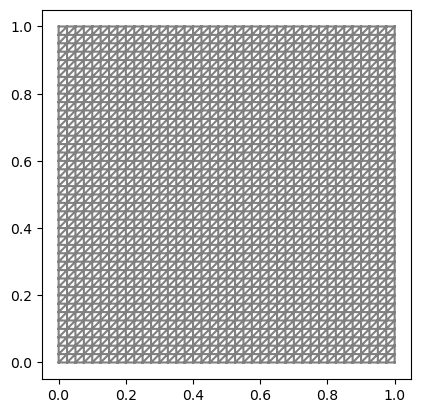

In [23]:
# mesh discretization
n_nodes = 41
n_elements = n_nodes - 1
mesh = fe.UnitSquareMesh(n_elements, n_elements)
V = fe.FunctionSpace(mesh, 'CG', 1)
fe.plot(mesh)
mesh_spacing = 1 / n_elements
mesh_spacing

In [24]:
# initial and Dirichlet boundary condition
ic_expression = fe.Constant(0)
u_n2 = fe.interpolate(ic_expression, V)
u_n1 = fe.interpolate(ic_expression, V)

def boundary(x, on_boundary):
    return on_boundary and fe.near(x[1], 0, eps=1e-14)

omega = 50 # Hz
bc_expression = fe.Expression(f'sin(6.2831 * omega * t)', degree=2, t=0, omega=omega)
bc = fe.DirichletBC(V, bc_expression, boundary)

# source term and Neumann boundary condition
f = fe.Expression('0', degree=0)
g = fe.Expression('0', degree=1)

In [25]:
# physical parameters

# specify wave speed in meters per second (from physical constants)
rho = 1000 # kg / m^3
mu0 = 4000 # Pa = N / m^2 = (kg m/s^2) / m^2 = kg / (m s^2)
mu1 = 16000 # Pa
c = np.sqrt(mu0 / rho) # (kg / (m s^2)) / (kg / m^3) = m^3 / (m s^2) = (m / s)^2
side_length = 0.2 # meters

# non-dimensionalize the wave speed
c /= side_length # side lengths per second

dt = 2e-4 # seconds

# check CFL condition
cfl_number = c * dt / mesh_spacing
print(cfl_number)
assert cfl_number <= 1, f'CFL condition violated ({c} x {dt} / {mesh_spacing} <= 1)'

total_time = 0.2 # seconds
n_steps = np.ceil(total_time / dt).astype(int)
n_steps

0.08


1000

# FEM derivation for linear elasticity

## Part 1: Derivation from first principles

First equation of motion:

\begin{align*}
    \nabla \cdot \sigma + \rho \mathbf{f} &= \rho \mathbf{u}'' \\
\end{align*}

Linear isotropic elasticity:

\begin{align*}
    \sigma &= \mathsf{E} \epsilon \\
    \sigma &= 2 \mu \epsilon + \lambda \operatorname{tr} (\epsilon) \mathbf{I} \\
\end{align*}

Kelvin-Voigt model of viscoelasticity:

\begin{align*}
    \sigma &= \mathsf{E} \epsilon + \eta \epsilon'\\
\end{align*}

Assume infinitesimal strain:

\begin{align*}
    \epsilon &= \frac{1}{2} \left( \nabla \mathbf{u} + \nabla \mathbf{u}^\top \right)
\end{align*}

Substitute:

\begin{align*}
    \nabla \cdot \left[ \mu \left(\nabla \mathbf{u} + \nabla \mathbf{u}^\top \right) + \lambda (\nabla \cdot \mathbf{u}) \mathbf{I} + \eta \epsilon' \right] + \rho \mathbf{f} &= \rho \mathbf{u}''
\end{align*}

Assume locally homogeneous (Navier-Cauchy equation):

\begin{align*}
    \mu \nabla^2 \mathbf{u} + (\lambda + \mu) \nabla (\nabla \cdot \mathbf{u}) + \nabla \cdot (\eta \epsilon') + \rho \mathbf{f} &= \rho \mathbf{u}''
\end{align*}

Assume incompressible:

\begin{align*}
    \mu \nabla^2 \mathbf{u} + \rho k \mathbf{u}' + \rho \mathbf{f} &= \rho \mathbf{u}''
\end{align*}

Define wave speed ($c = \sqrt{\mu / \rho}$):

\begin{align*}
    c^2 \nabla^2 \mathbf{u} + k \mathbf{u}' + \mathbf{f} &= \mathbf{u}''
\end{align*}


## Part 2: Time-stepping FEM formulation

Time discretization:

\begin{align*}
    c^2 \nabla^2 \mathbf{u} + \mathbf{f} &= \mathbf{u}'' \\
    c^2 \nabla^2 \mathbf{u}^n + \mathbf{f}^n &= \frac{\mathbf{u}^n - 2 \mathbf{u}^{n-1} + \mathbf{u}^{n-2}}{\Delta t^2} \\
    c^2 \Delta t^2 \nabla^2 \mathbf{u}^n + \Delta t^2 \mathbf{f}^n &= \mathbf{u}^n - 2 \mathbf{u}^{n-1} + \mathbf{u}^{n-2} \\
    c^2 \Delta t^2 \nabla^2 \mathbf{u}^n - \mathbf{u}^n &= -2 \mathbf{u}^{n-1} + \mathbf{u}^{n-2} - \Delta t^2 \mathbf{f}^n \\
    \mathbf{u}^n - c^2 \Delta t^2 \nabla^2 \mathbf{u}^n &= 2 \mathbf{u}^{n-1} - \mathbf{u}^{n-2} + \Delta t^2 \mathbf{f}^n \\
\end{align*}

Spatial discretization:

\begin{align*}
    \int_\Omega \left( \mathbf{u}^n - c^2 \Delta t^2 \nabla^2 \mathbf{u}^n \right) \cdot \mathbf{v} \, dx &= \int_\Omega \left( 2 \mathbf{u}^{n-1} - \mathbf{u}^{n-2} + \Delta t^2 \mathbf{f}^n \right) \cdot \mathbf{v} \, dx \\
    \int_\Omega \mathbf{u}^n \cdot \mathbf{v} - c^2 \Delta t^2 \nabla^2 \mathbf{u}^n \cdot \mathbf{v} \, dx &= \int_\Omega \left( 2 \mathbf{u}^{n-1} - \mathbf{u}^{n-2} + \Delta t^2 \mathbf{f}^n \right) \cdot \mathbf{v} \, dx \\
    \int_\Omega \mathbf{u}^n \cdot \mathbf{v} + c^2 \Delta t^2 \nabla \mathbf{u}^n \cdot \nabla \mathbf{v} \, dx &= \int_\Omega \left( 2 \mathbf{u}^{n-1} - \mathbf{u}^{n-2} + \Delta t^2 \mathbf{f}^n \right) \cdot \mathbf{v} \, dx + \oint_{\delta\Omega} \mathbf{g} \, ds \\
\end{align*}

In [26]:
# variational form
u = fe.TrialFunction(V)
v = fe.TestFunction(V)
a = (
    u * v * dx + 
    (c * dt)**2 * dot(grad(u), grad(v)) * dx
)
L = (
    (2 * u_n1 - u_n2 + dt**2 * f) * v * dx + 
    (g * v) * ds
)

In [33]:
# damped inhomogeneous version

class AbsorbingBoundary(fe.UserExpression):
    def value_shape(self):
        return ()
    def eval(self, values, x):
        if x[0] < 0.05 or x[0] > 0.95 or x[1] > 0.95:
            values[0] = -1000
        else:
            values[0] = 0

k = fe.interpolate(AbsorbingBoundary(), V)

class InhomogeneousMaterial(fe.UserExpression):
    def value_shape(self):
        return ()
    def eval(self, values, x):
        dist = np.sqrt((x[0] - 0.5)**2 + (x[1] - 0.5)**2)
        if dist < 0.25: # target
            values[0] = np.sqrt(mu1 / rho) / side_length
        else: # background
            values[0] = np.sqrt(mu0 / rho) / side_length

c = fe.interpolate(InhomogeneousMaterial(), V)
u_n2 = fe.interpolate(ic_expression, V)
u_n1 = fe.interpolate(ic_expression, V)

u = fe.TrialFunction(V)
v = fe.TestFunction(V)
a = (
    (2 - k*dt) * u*v + 
    2*(c*dt)**2 * dot(grad(u), grad(v))
) * dx
L = (
    (4*u_n1 - (2 + k*dt)*u_n2 + 2*dt**2 * f) * v * dx +
    (g*v) * ds
)

In [34]:
# get mapping from dofs to array indices
xyz = V.tabulate_dof_coordinates()
x = xyz[:,0]
y = xyz[:,1]
print(xyz.shape)

inds = np.argsort([n_nodes * x + y for x,y in xyz])
xyz[inds]

(1681, 2)


array([[0.   , 0.   ],
       [0.   , 0.025],
       [0.   , 0.05 ],
       ...,
       [1.   , 0.95 ],
       [1.   , 0.975],
       [1.   , 1.   ]])

In [29]:
%%time
import tqdm

u_n2.interpolate(ic_expression)
u_n1.interpolate(ic_expression)
u = fe.Function(V)

array = np.zeros((n_steps + 1, n_nodes, n_nodes))

t = 0
for i in tqdm.tqdm(range(n_steps)):
    t += dt
    bc_expression.t = t
    fe.solve(a == L, u, bc)
    u_n2.assign(u_n1)
    u_n1.assign(u)

    values = u.vector().get_local()
    array[i+1,...] = values[inds].reshape((n_nodes, n_nodes))


  0%|          | 0/1000 [00:00<?, ?it/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


  1%|          | 9/1000 [00:10<14:39,  1.13it/s]  

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


  3%|▎         | 27/1000 [00:11<03:17,  4.93it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


  4%|▍         | 45/1000 [00:11<01:21, 11.69it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


  6%|▋         | 63/1000 [00:11<00:41, 22.44it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


  8%|▊         | 81/1000 [00:11<00:25, 36.68it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 10%|▉         | 99/1000 [00:12<00:17, 51.34it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 12%|█▏        | 116/1000 [00:12<00:14, 61.45it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 13%|█▎        | 133/1000 [00:12<00:12, 69.90it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 15%|█▍        | 149/1000 [00:12<00:11, 72.46it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 16%|█▋        | 165/1000 [00:12<00:11, 75.38it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 18%|█▊        | 181/1000 [00:13<00:10, 75.31it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 20%|█▉        | 197/1000 [00:13<00:10, 76.13it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 21%|██▏       | 214/1000 [00:13<00:10, 78.06it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 23%|██▎       | 230/1000 [00:13<00:10, 76.34it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 25%|██▍       | 246/1000 [00:13<00:09, 76.11it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 26%|██▌       | 262/1000 [00:14<00:09, 76.06it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 28%|██▊       | 279/1000 [00:14<00:09, 76.10it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 30%|██▉       | 295/1000 [00:14<00:09, 76.03it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 31%|███       | 312/1000 [00:14<00:08, 77.95it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 33%|███▎      | 329/1000 [00:15<00:08, 78.95it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 35%|███▍      | 346/1000 [00:15<00:08, 78.60it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 36%|███▋      | 364/1000 [00:15<00:07, 80.28it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 38%|███▊      | 382/1000 [00:15<00:07, 81.08it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 39%|███▉      | 391/1000 [00:15<00:07, 79.39it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 41%|████      | 408/1000 [00:16<00:07, 78.74it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 42%|████▏     | 424/1000 [00:16<00:07, 76.92it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 44%|████▍     | 440/1000 [00:16<00:07, 75.42it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 46%|████▌     | 457/1000 [00:16<00:06, 78.33it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 47%|████▋     | 473/1000 [00:16<00:06, 77.15it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 49%|████▉     | 489/1000 [00:17<00:06, 75.93it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 50%|█████     | 505/1000 [00:17<00:06, 77.21it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 52%|█████▏    | 522/1000 [00:17<00:06, 78.48it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 54%|█████▍    | 539/1000 [00:17<00:05, 79.22it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 56%|█████▌    | 556/1000 [00:17<00:05, 79.18it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 57%|█████▋    | 572/1000 [00:18<00:05, 76.93it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 59%|█████▉    | 589/1000 [00:18<00:05, 77.49it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 61%|██████    | 606/1000 [00:18<00:04, 79.02it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 62%|██████▏   | 624/1000 [00:18<00:04, 81.98it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 64%|██████▍   | 642/1000 [00:19<00:04, 79.27it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 66%|██████▌   | 660/1000 [00:19<00:04, 80.89it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 68%|██████▊   | 678/1000 [00:19<00:03, 80.62it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 70%|██████▉   | 696/1000 [00:19<00:03, 79.71it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 71%|███████▏  | 713/1000 [00:19<00:03, 79.28it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 73%|███████▎  | 730/1000 [00:20<00:03, 79.34it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 74%|███████▍  | 738/1000 [00:20<00:03, 76.40it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 76%|███████▌  | 755/1000 [00:20<00:03, 78.25it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 77%|███████▋  | 771/1000 [00:20<00:02, 78.45it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 79%|███████▊  | 787/1000 [00:20<00:02, 75.82it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 80%|████████  | 804/1000 [00:21<00:02, 77.96it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 82%|████████▏ | 820/1000 [00:21<00:02, 77.28it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 84%|████████▎ | 837/1000 [00:21<00:02, 78.63it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 85%|████████▌ | 853/1000 [00:21<00:01, 78.39it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 88%|████████▊ | 877/1000 [00:22<00:01, 75.93it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 89%|████████▉ | 893/1000 [00:22<00:01, 76.65it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 91%|█████████ | 909/1000 [00:22<00:01, 76.17it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 93%|█████████▎| 926/1000 [00:22<00:00, 77.92it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 94%|█████████▍| 943/1000 [00:22<00:00, 79.25it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 96%|█████████▌| 960/1000 [00:23<00:00, 78.17it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 98%|█████████▊| 978/1000 [00:23<00:00, 80.55it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


 99%|█████████▊| 987/1000 [00:23<00:00, 80.31it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


100%|██████████| 1000/1000 [00:23<00:00, 42.29it/s]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
CPU times: user 12.6 s, sys: 407 ms, total: 13 s
Wall time: 23.7 s


In [37]:
%%time
import tqdm

u_n2.interpolate(ic_expression)
u_n1.interpolate(ic_expression)
u = fe.Function(V)

# assemble LHS only once before time-stepping
A = fe.assemble(a)

array = np.zeros((n_steps + 1, n_nodes, n_nodes))

t = 0
for i in tqdm.tqdm(range(n_steps)):
    t += dt
    b = fe.assemble(L)
    bc_expression.t = t
    bc.apply(A, b)
    fe.solve(A, u.vector(), b)
    u_n2.assign(u_n1)
    u_n1.assign(u)

    values = u.vector().get_local()
    array[i+1,...] = values[inds].reshape((n_nodes, n_nodes))

100%|██████████| 1000/1000 [00:08<00:00, 118.18it/s]

CPU times: user 8.18 s, sys: 123 ms, total: 8.3 s
Wall time: 8.48 s


In [38]:
import xarray as xr
import hvplot.xarray

array = xr.DataArray(
    array,
    dims=['t', 'x', 'y'],
    coords={
        't': np.arange(0, n_steps + 1) * dt,
        'x': np.linspace(0, 1, n_nodes),
        'y': np.linspace(0, 1, n_nodes)
    }
)
array.hvplot(
    groupby=['t'],
    x='x',
    y='y',
    data_aspect=1,
    clim=(-2, 2),
    cmap='seismic',
    widget_type='scrubber',
    widget_location='bottom'
)

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber')
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=1000, width=550)

In [ ]:
array.hvplot(groupby=['t', 'x'], x='y', ylim=[-2, 2], widget_location='bottom')

In [ ]:
array

In [ ]:
%%time
import os
import subprocess

def create_video(video_name, array):
    
    print('Creating video frames...')
    os.makedirs(video_name, exist_ok=True)
    for i, frame in enumerate(array):
        frame_file = video_name + f'/frame{i:04d}.png'
        plt.imshow(frame.T, vmin=-2, vmax=2, cmap='seismic')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.savefig(frame_file)
        print(frame_file)
        
    print('Creating video...')
    os.chdir(video_name)
    subprocess.call([
        'ffmpeg', '-framerate', '30', '-i', 'file%04d.png', '-r', '30', '-pix_fmt', 'yuv420p', f'{video_name}.mp4'
    ])

create_video('my_video4', array.values)